In [1]:
import torch
import torch.utils.data
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt

/home/user/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
y = torch.load('../data/target_tensor_f.pt')

In [3]:
X = torch.load('../data/features_tensor_f.pt')

In [4]:
device = torch.device('cuda')

In [5]:
class Data(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = x.size(dim=0)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

dataset = Data(X[:, 2:], y)
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_set, valid_set = torch.utils.data.random_split(dataset, [train_size, valid_size])

In [39]:
torch.manual_seed(41)

n_inputs = X.size(dim=1) - 2

model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(n_inputs, affine=False),
    torch.nn.Linear(n_inputs, 500),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(500),
    #torch.nn.Dropout1d(p=0.1),
    torch.nn.Linear(500, 200),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(200),
    #torch.nn.Dropout1d(p=0.1),
    torch.nn.Linear(200, 50),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(50),
    torch.nn.Linear(50, 1)
)

model = model.to(device)

In [43]:
def initialize_weights(layer):
  if isinstance(layer, torch.nn.Linear):
    layer.weight.data.uniform_(0.0, 0.2)
    layer.bias.data.fill_(0.1)

model.apply(initialize_weights)
epoch_number = 0
best_valid_score = (0, 0)
train_scores = []
valid_scores = []

Epoch  12 . The worst loss value:  0.552363932132721 , the best loss value:  0.49098336696624756
Train score: 0.6412740035644141, validation score: 0.5652027251357585
Best valid score: 0.5693695490611914, best epoch: 11


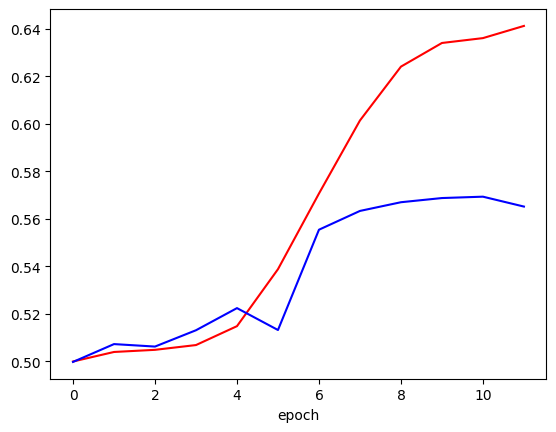

In [47]:
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1.0e-2)

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=10000)

for _ in range(1):
    model.train()
    worst_loss_value = 0
    best_loss_value = 5000 
    scores = []
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        X_train_batch = X_train_batch.to(device)
        y_train_batch = y_train_batch.to(device)
        y_train_batch_pred = model.forward(X_train_batch)

        loss_value = loss(y_train_batch_pred, y_train_batch)
        if loss_value.item() > worst_loss_value:
            worst_loss_value = loss_value.item()
        if loss_value.item() < best_loss_value:
            best_loss_value = loss_value.item()

        loss_value.backward()
        optimizer.step()

        scores.append(metrics.roc_auc_score(y_train_batch.cpu().detach(), y_train_batch_pred.round().cpu().detach())) 

    epoch_number += 1
    print("Epoch ", epoch_number, ". The worst loss value: ", worst_loss_value, ", the best loss value: ", best_loss_value)
    train_mean_score = sum(scores) / len(scores)
    train_scores.append(train_mean_score)

    model.eval()
    valid_loader = torch.utils.data.DataLoader(dataset=valid_set, batch_size=30000)
    scores = []
    with torch.no_grad():
        for X_valid_batch, y_valid_batch in valid_loader:
            X_valid_batch = X_valid_batch.to(device)
            y_valid_batch = y_valid_batch.to(device)
            y_valid_batch_pred = model.forward(X_valid_batch)
            scores.append(metrics.roc_auc_score(y_valid_batch.cpu(), y_valid_batch_pred.round().cpu()))

    valid_mean_score = sum(scores) / len(scores)
    valid_scores.append(valid_mean_score)
    print(f"Train score: {train_mean_score}, validation score: {valid_mean_score}")
    if valid_mean_score > best_valid_score[0]:
        best_valid_score = (valid_mean_score, epoch_number) 
    print(f"Best valid score: {best_valid_score[0]}, best epoch: {best_valid_score[1]}")

plt.plot(train_scores, '-r', label='Train')
plt.plot(valid_scores, '-b', label='Validation')
plt.xlabel('epoch')
plt.show()

    